### NEE calculated using USTAR CUT / VUT thresholds for USNE-1 maize-soybean site
#### Years 2015 - 2022

In [123]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import preprocessing
import seaborn as sns
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [9]:
target = 'NEE'
observed_df = pd.read_csv('datasets/extractedNEE_CUT_REF_NIGHT_Final'  + '.csv')

In [95]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df


mdays=[31,28,31,30,31,30,31,31,30,31,30,31]

def isleap(year):
    leap=False
    if year % 4 == 0 and year % 100 != 0:
        leap=True
    elif year % 100 == 0:
        leap=False
    elif year % 400 ==0:
        leap=True
    else:
        leap=False
    return leap
def dayofyear(year,month,day):
    doy=0
    for mm in range(0,month):
        days=mdays[mm]
        if mm==1:
            if isleap(year):
                days=29
        for dd in range(0,days):
            if mm < month-1:
                doy=doy+1
            else:
                if dd < day:
                    doy=doy+1
    return doy

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

def nee_cumulative_to_daily(df: pd.DataFrame) -> pd.DataFrame:
    df['DOY'] = df['DOY'].astype(int)

    # Divide only rows with DOY > 0
    df['ECO_NPP'] = df.apply(lambda row: row['ECO_NPP']/row['DOY'] if row['DOY'] != 0 else row['ECO_NPP'], axis=1)
    df['ECO_RH'] = df.apply(lambda row: row['ECO_RH']/row['DOY'] if row['DOY'] != 0 else row['ECO_RH'], axis=1)

    df['NEE'] = df['ECO_NPP'] - df['ECO_RH']
    
    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)
    
    x['WIND'] = x['WIND'] / 100
    
    x['DATE'] =  pd.to_datetime(x['DATE'])
    
    x['DOY'] = 0
    for i in range( x.shape[0]):
        x['DOY'][i] = dayofyear(x['DATE'][i].year, x['DATE'][i].month, x['DATE'][i].day)
        
    x['YEAR'] = x['DATE'].dt.year
    
    x.drop(['DATE'],axis=1)
    
    

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

y = df[target].copy()

#y = df[target].copy()
#df = df.drop(target, axis=1)

### NEE calculated using PR ecosys , (Gross primary production - Ecosystem respiration)

In [96]:
def plot_against_time(eco_nee : pd.Series, obs_nee : pd.Series, title: str = 'NEE by time of the year' , xlabel: str = 'Simulated' , ylabel: str = 'Measured'):
    dates = np.arange(0, len(eco_nee))

    # Define the two NEE datasets
    nee_procedural = eco_nee
    nee_eddy_covariance = obs_nee

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(dates, nee_procedural, label= xlabel, color='blue')
    ax.plot(dates, nee_eddy_covariance, label= ylabel, color='red')

    # Add axis labels and legend
    ax.set_xlabel('Samples')
    ax.set_ylabel('NEE g C m-2 day-1')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()

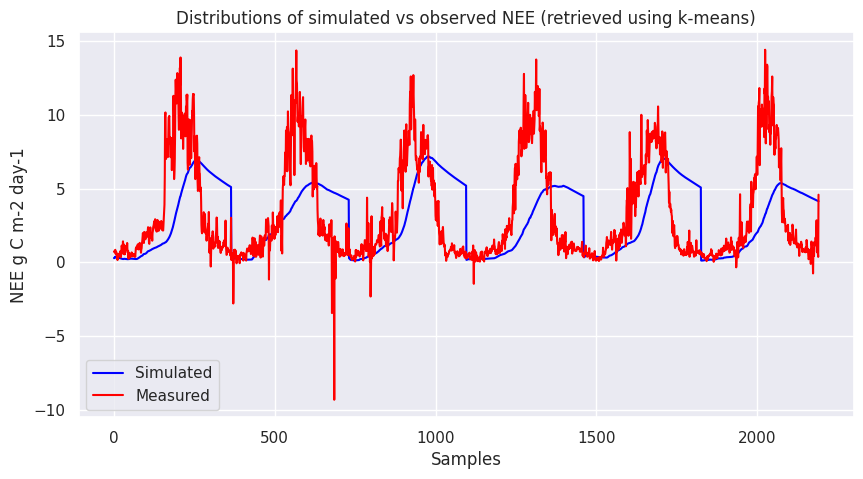

In [97]:
plot_against_time(df_irr['NEE'][:2192], observed_df['NEE'],  'Distributions of simulated vs observed NEE (retrieved using k-means)')

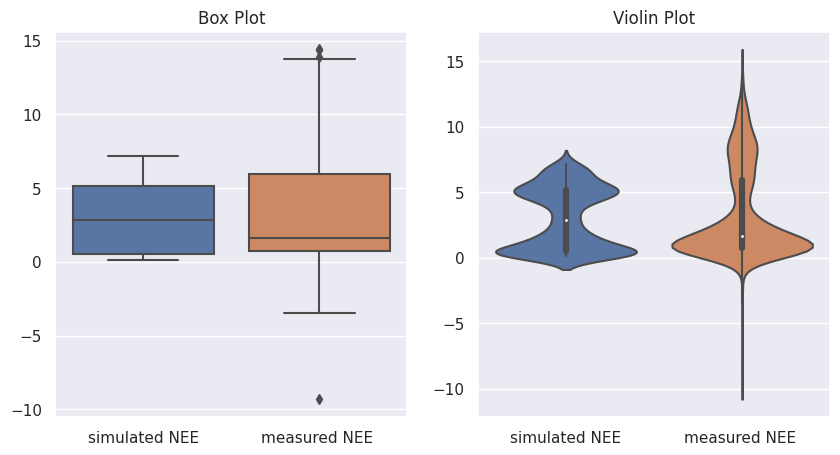

In [98]:
dat = pd.DataFrame({'simulated NEE' : df_irr['NEE'][:2192], 'measured NEE ' : observed_df['NEE']})
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Create a box plot on the left subplot
sns.boxplot(data=dat, ax=ax1)
ax1.set_title('Box Plot')

# Create a violin plot on the right subplot
sns.violinplot(data=dat, ax=ax2)
ax2.set_title('Violin Plot')

# Show the figure
plt.show()

In [99]:
observed_df['initial planting density (m-2)1'] = 8.2
observed_df['DOY'] = observed_df['DOY'].astype(int)
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])


feat_cols.append('YEAR')

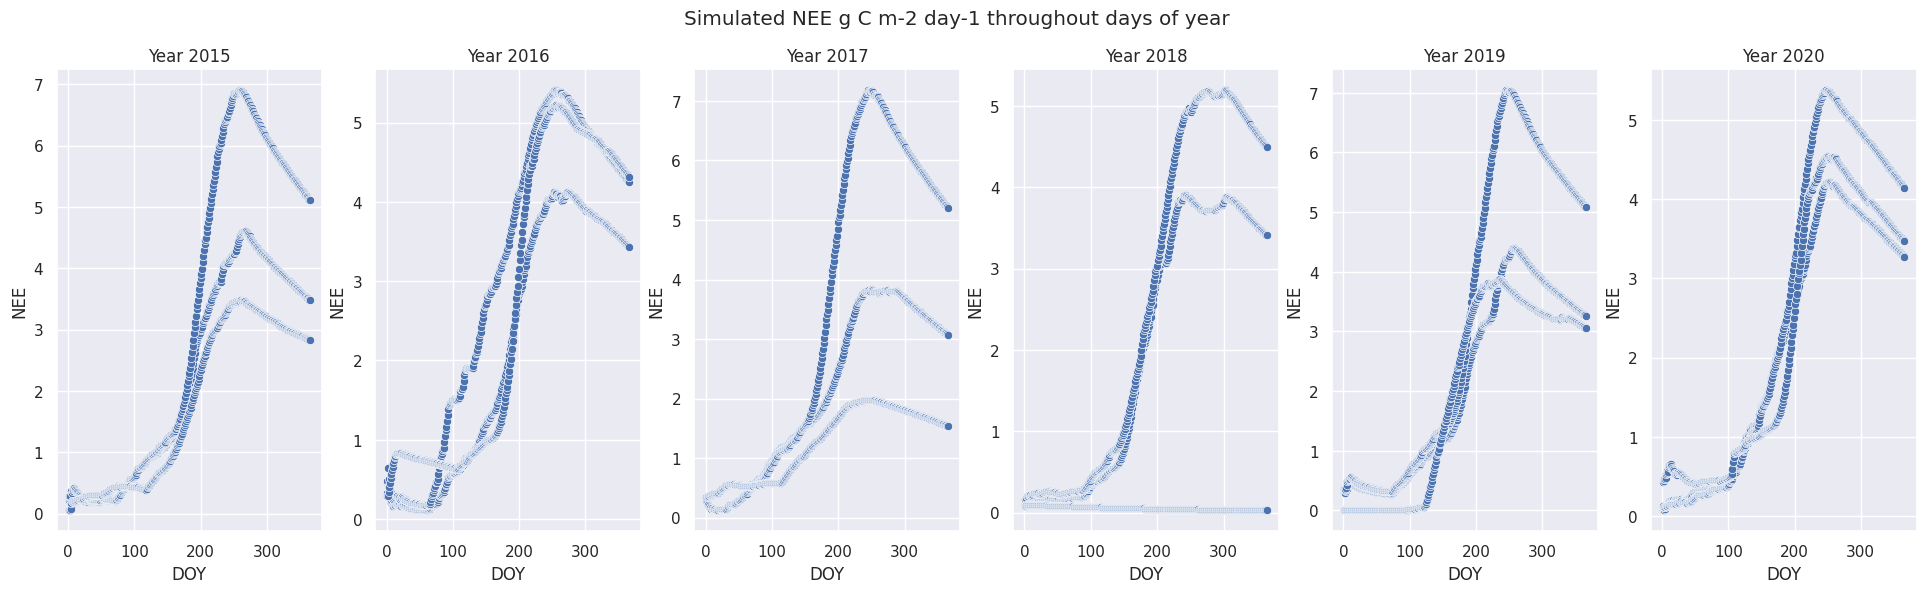

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [120]:
strt_yr = 2015

yrs = 6

# Create a figure with subplots
fig, axs = plt.subplots(1, yrs, figsize=(4*yrs, 6))
for i in range(6): 
    cur = df.loc[df['YEAR'] == strt_yr]
    
    
    
    plt.figure()
    # Plot each line with different color and label
    sns.scatterplot(x=cur['DOY'], y=cur['NEE'], ax=axs[i],  alpha=1)
    axs[i].set_title(f'Year {strt_yr}')
    
    strt_yr += 1
fig.suptitle('Simulated NEE g C m-2 day-1 throughout days of year')

plt.subplots_adjust(wspace=0.3)

plt.show()

In [103]:
df.loc[df['YEAR'] == 2015]

,DATE,DOY,SOIL_CO2_FLUX,ECO_CO2_FLUX,CH4_FLUX,O2_FLUX,CO2_LIT,O2_LIT,H_EVAPN,H_RUNOFF,...,END_SEED_FILL,FLORAL_INIT.,JOINTING,NOT_ALIVE,SEED_FILL,SEED_MASS_SET,SEED_NO._SET,YEAR,NEE,PLANTING
0,2015-01-01,1,-0.255585,-0.255585,0.000761,0.276700,370.324575,15.367582,-0.000728,0.0,...,0,0,0,1,0,0,0,2015,0.236561,NaN
1,2015-01-02,2,-0.241709,-0.241709,0.000744,-0.168380,370.360742,15.798648,-0.009315,0.0,...,0,0,0,1,0,0,0,2015,0.229185,NaN
2,2015-01-03,3,-0.272869,-0.272869,0.000786,-0.006056,370.420192,14.854394,-0.009618,0.0,...,0,0,0,1,0,0,0,2015,0.239400,NaN
3,2015-01-04,4,-0.649682,-0.649682,0.000937,0.387433,370.668192,14.012000,-0.004694,0.0,...,0,0,0,1,0,0,0,2015,0.328765,NaN
4,2015-01-05,5,-0.315353,-0.315353,0.000760,0.391184,370.359367,15.584626,-0.000703,0.0,...,0,0,0,1,0,0,0,2015,0.318535,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2015-12-27,361,-1.031139,-1.031139,0.000383,1.286885,361.800567,14.719593,0.006997,0.0,...,0,0,0,1,0,0,0,2015,2.854223,0.0
361,2015-12-28,362,-0.946286,-0.946286,0.000388,1.161574,361.981225,15.500575,0.001913,0.0,...,0,0,0,1,0,0,0,2015,2.848931,0.0
362,2015-12-29,363,-0.696751,-0.696751,0.000400,0.513150,361.435938,15.316497,0.006222,0.0,...,0,0,0,1,0,0,0,2015,2.843007,0.0
363,2015-12-30,364,-0.576863,-0.576863,0.000432,0.699276,360.593946,15.115813,0.005832,0.0,...,0,0,0,1,0,0,0,2015,2.836799,0.0


In [ ]:
df['DATE']

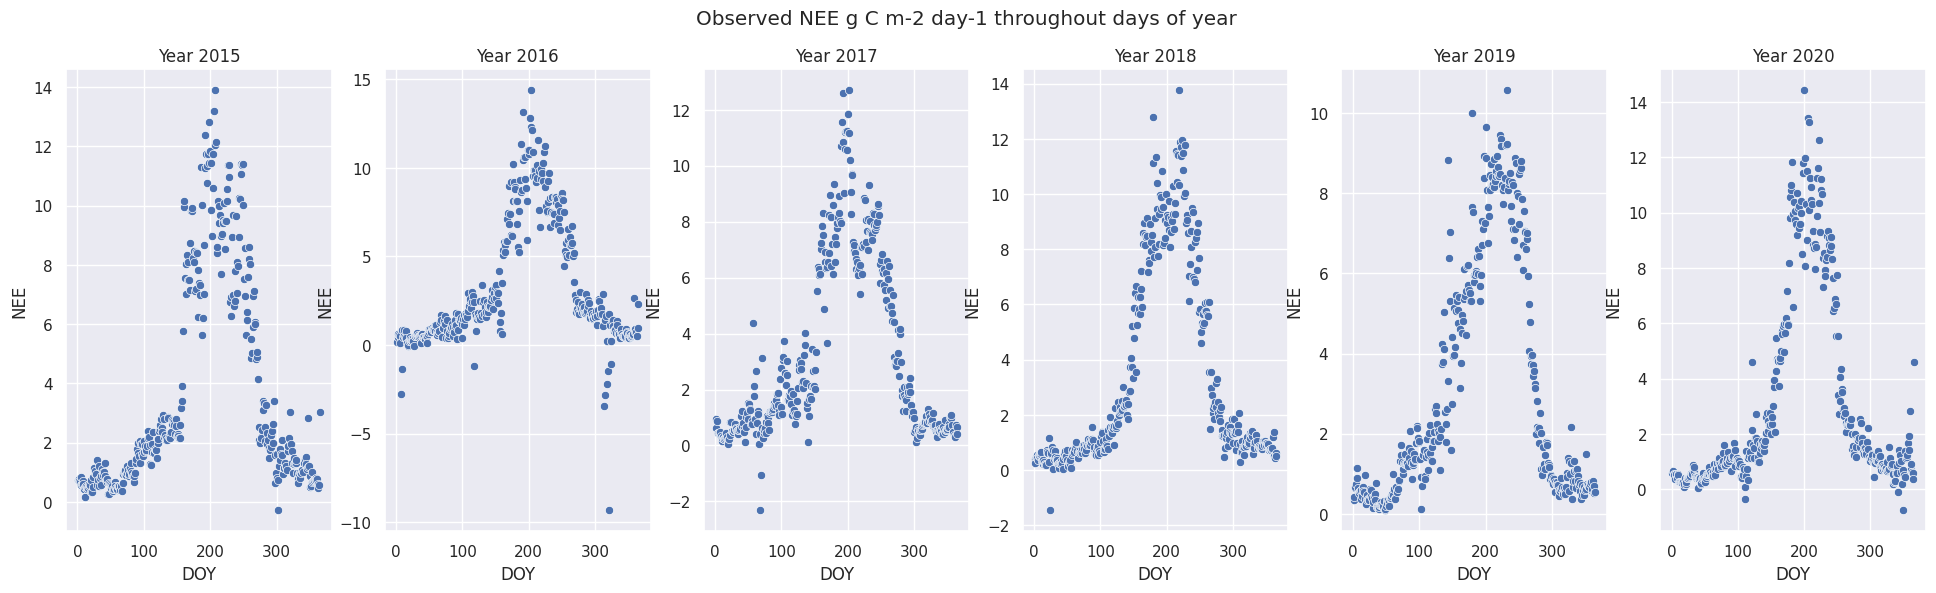

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [102]:
strt_yr = 2015

yrs = 6

# Create a figure with subplots
fig, axs = plt.subplots(1, yrs, figsize=(4*yrs, 6))
for i in range(6): 
    cur = observed_df.loc[observed_df['YEAR'] == strt_yr]
    
    
    
    plt.figure()
    plt.tight_layout()
    sns.scatterplot(x=cur['DOY'], y=cur['NEE'], ax=axs[i],  alpha=1)
    axs[i].set_title(f'Year {strt_yr}')
    
    strt_yr += 1
    

fig.suptitle('Observed NEE g C m-2 day-1 throughout days of year')

plt.subplots_adjust(wspace=0.3)

plt.show()

In [159]:
season_map = {
1 :'WINTER' ,
2:'SPRING',
3:'SUMMER',
4:'AUTUMN'
}

df['SEASON'] = df['DATE'].dt.month%12 // 3 + 1
df['SEASON'] =df['SEASON'].map(season_map)